Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [x] Get your model's test accuracy. (One time, at the end.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [x] Do one-hot encoding.
- [x] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [x] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1389]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [1408]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
# for e,l in enumerate(range(100)):
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

pd.options.mode.chained_assignment = None  # default='warn'

# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()


california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')


df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'


# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])


# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])


def update_to_year():
    df['Date'] = pd.to_datetime(df.Date)
    up_date = []
    for date in df['Date']:
        up_date.append(date.year)
    df['Date'] = up_date

# convert 'Date' column to dtype datetime:    
# change date column to just be the year 
update_to_year()

# map values to replace nans as 0 and 'X or x' as 1:
import numpy as np
for i in df.iloc[:,21:-1].columns:
    df[str(i)] = df[str(i)].map({'X':1,'x':1,np.nan:0})
# fill na values with the average of all values in a given column:
def fill_with_mean(df,columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mean())

# call the fill function:
fill_list = ['Length','Circum','Volume','Yelp','Google']
fill_with_mean(df,fill_list)

# instantiat a list of columns to drop:
cols_to_drop = ['Chips','Mass (g)','Density (g/mL)']
# drop columns from data that are useless
df.drop(columns=cols_to_drop,inplace=True)


# Split the data:

# train = df.loc[(df['Date'] <= 2016)]   # before doing train_test_split
# val = df.loc[(df['Date'] == 2017)]     # " "
test = df.loc[(df['Date'] >= 2018)] 

# use model selection to randomly select samples for us:
from sklearn.model_selection import train_test_split

train,val = train_test_split(df, random_state=37)


# instantiate target data:
target = 'Great'
y_train = train[target]
y_val = val[target]
y_test = test[target]

# baseline:
# Majority class of burritos are not great.
import seaborn as sns
import matplotlib.pyplot as plt
# sns.countplot(y_train)

# Guesses all burritos are not-great:
majority_class = y_train.mode()[0]
y_pred = [majority_class]*len(y_train)

# now lets get an accuracy score for the baseline:
from sklearn.metrics import accuracy_score
print(
    f"The accuracy of the baseline model: {int(round(accuracy_score(y_train,y_pred),2)*100)}%")
# function to drop desired columns:
def drop_cols_on_all_dfs(df_list,col_to_drop):
    for i in df_list:
        i.drop(columns=col_to_drop,inplace=True)

# call drop function:
drop_cols_on_all_dfs([train,val,test],['Date','Great','Queso','Lobster',
                                    'Zucchini'])    

'''
Instantiate features:
'''
# features = list(train.columns[:19].drop(['Yelp','Google']))
# features = list(train.columns.drop(['Yelp','Google','Unreliable','NonSD']))
features = list(train.columns)

# instantiate our train/val/test matracies:
X_train = train[features]
X_val = val[features]
X_test = test[features]

# Perform one hot encoding on the catagorical features:
import category_encoders as ce 
# instantiate the encoder:
encoder = ce.OneHotEncoder(use_cat_names=True)
# use the encoder on all data:
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Impute the data:
from sklearn.impute import SimpleImputer
# instantiate imputer:
imputer = SimpleImputer(strategy='median') 
# impute the data:
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

# Scale the data:
from sklearn.preprocessing import StandardScaler
# instantiate scaler:
scaler = StandardScaler()
# standardize data with the scaler:
X_train_scaled = scaler.fit_transform(X_train_imputed) 
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Perform logistic regression:
from sklearn.linear_model import LogisticRegression
# instantiate logistic regression model:
model = LogisticRegression()
# fit the processed data to the model:
model.fit(X_train_scaled,y_train)
# predict on our validation data:
y_pred = model.predict(X_val_scaled)

# aquire validation accuracy score:
validation_score = accuracy_score(y_val,y_pred)
print(f"\nValidation accuracy score: {str(round(validation_score,2)*100)[:2]}%")

# predict on our test data:
y_pred = model.predict(X_test_scaled)

# aquire test accuracy score:
test_score = accuracy_score(y_test,y_pred)
print(f"\nTest accuracy score: {str(round(test_score,2)*100)[:2]}%")
# if test_score > .80:
#     print(e,f"\nTest accuracy score: {str(round(test_score,2)*100)[:2]}%")

The accuracy of the baseline model: 56%

Validation accuracy score: 83%

Test accuracy score: 87%


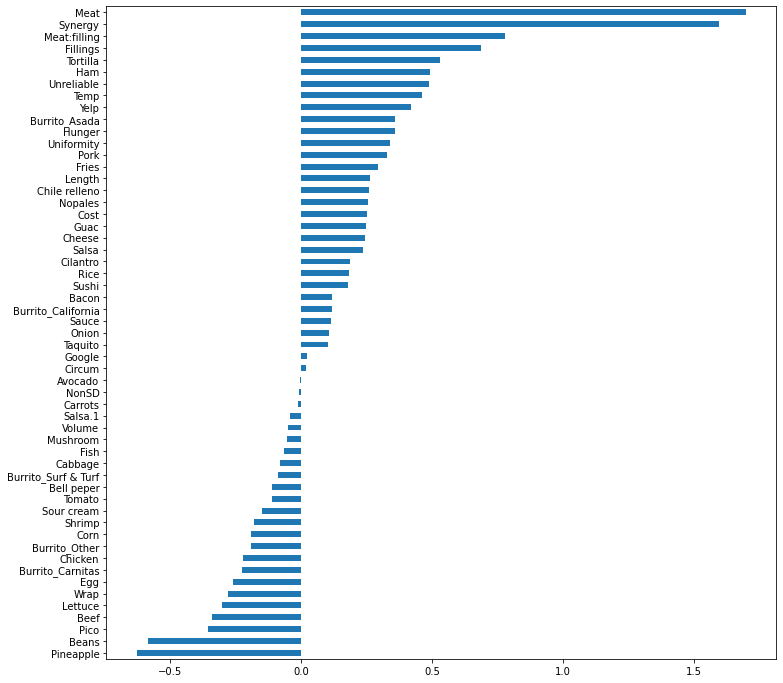

In [1397]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(12,12))
coefficients.sort_values().plot.barh();

In [1403]:
state_87 = 37